# 1. Importando bibliotecas

In [486]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
# para encoding
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
# para calculo del vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# para balanceo de clases
from imblearn.over_sampling import SMOTE
# para modelado
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# para validacion
from sklearn.model_selection import cross_val_score ,train_test_split, StratifiedKFold
from imblearn.pipeline import Pipeline
# para evaluar metricas
from sklearn.metrics import f1_score, make_scorer
from sklearn.base import clone
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score, roc_auc_score
from sklearn.metrics import classification_report
# para optimización de hiperparametros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# para calibrado
from sklearn.calibration import CalibratedClassifierCV

# 2. Carga de datos

In [487]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [488]:
df = pd.read_csv('/content/drive/MyDrive/ONE/HACKATHON/DATASET/DF_FEATURE_ENGINNERING/dataset_feature_enginnering_final.csv')

In [489]:
df.sample(5)

,antiguedad,plan,metodo_pago,tipo_contrato,frecuencia_uso,cambios_plan,facturas_impagas,tickets_soporte,canal_adquisicion,friccion_del_servicio,engagement_score,valor_plan_num,ratio_valor_uso,riesgo_financiero,cliente_problematico,early_churn_risk,premium_mensual,churn
3159,18,premium,efectivo,mensual,20,3,1,9,call_center,0.428571,0.431667,14.99,0.713810,14.99,0,0,1,1
3322,57,premium,efectivo,mensual,30,3,2,5,redes_sociales,0.161290,0.662500,14.99,0.483548,29.98,0,0,1,0
3669,10,basico,tarjeta_debito,mensual,11,2,1,0,referido,0.000000,0.351667,4.99,0.415833,4.99,0,0,0,0
2722,48,estandar,efectivo,anual,9,3,3,5,call_center,0.500000,0.360000,9.99,0.999000,29.97,0,0,0,1
3651,15,estandar,tarjeta_credito,anual,23,2,0,21,web,0.875000,0.524167,9.99,0.416250,0.00,0,0,0,0


In [490]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251 entries, 0 to 4250
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   antiguedad             4251 non-null   int64  
 1   plan                   4251 non-null   object 
 2   metodo_pago            4251 non-null   object 
 3   tipo_contrato          4251 non-null   object 
 4   frecuencia_uso         4251 non-null   int64  
 5   cambios_plan           4251 non-null   int64  
 6   facturas_impagas       4251 non-null   int64  
 7   tickets_soporte        4251 non-null   int64  
 8   canal_adquisicion      4251 non-null   object 
 9   friccion_del_servicio  4251 non-null   float64
 10  engagement_score       4251 non-null   float64
 11  valor_plan_num         4251 non-null   float64
 12  ratio_valor_uso        4251 non-null   float64
 13  riesgo_financiero      4251 non-null   float64
 14  cliente_problematico   4251 non-null   int64  
 15  earl

In [491]:
# Proporcion de churn

df['churn'].value_counts(normalize=True)

,proportion
churn,
0,0.746177
1,0.253823


# 3. Selección de variables explicativas y variable objetivo

In [492]:
X = df.drop(columns='churn')
y = df['churn']

columnas = X.columns

# 4. Encoding

In [493]:
columnas_categoricas = ['plan', 'metodo_pago', 'tipo_contrato', 'canal_adquisicion']

columnas_numericas = [
    # Contractuales originales (6)
    'antiguedad',
    'frecuencia_uso',
    'cambios_plan',
    'facturas_impagas',
    'tickets_soporte',
    # Features engineerizadas (7)
    'friccion_del_servicio',
    'engagement_score',
    'valor_plan_num',
    'ratio_valor_uso',
    'riesgo_financiero',
    'cliente_problematico',
    'early_churn_risk',
    'premium_mensual'
]

In [494]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

columnas_cat = encoder.fit_transform(X[columnas_categoricas])

df_cat = pd.DataFrame(columnas_cat, columns=encoder.get_feature_names_out(columnas_categoricas))

df_codificado = pd.concat([X[columnas_numericas].reset_index(drop=True), df_cat.reset_index(drop=True)], axis=1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
df_codificado['churn'] = y

print(df_codificado)
print(df_codificado.info())

      antiguedad  frecuencia_uso  cambios_plan  facturas_impagas  \
0             16              15             3                 2   
1            120               2             2                 3   
2             29              28             3                 2   
3             48               9             1                 0   
4             13              19             0                 1   
...          ...             ...           ...               ...   
4246          49              16             2                 2   
4247          39              18             1                 1   
4248          20               7             1                 0   
4249          51              15             2                 2   
4250          60               4             1                 2   

      tickets_soporte  friccion_del_servicio  engagement_score  \
0                   0               0.000000          0.360000   
1                  10               3.333333       

# 5. Analisis de correlación y multicolinearidad

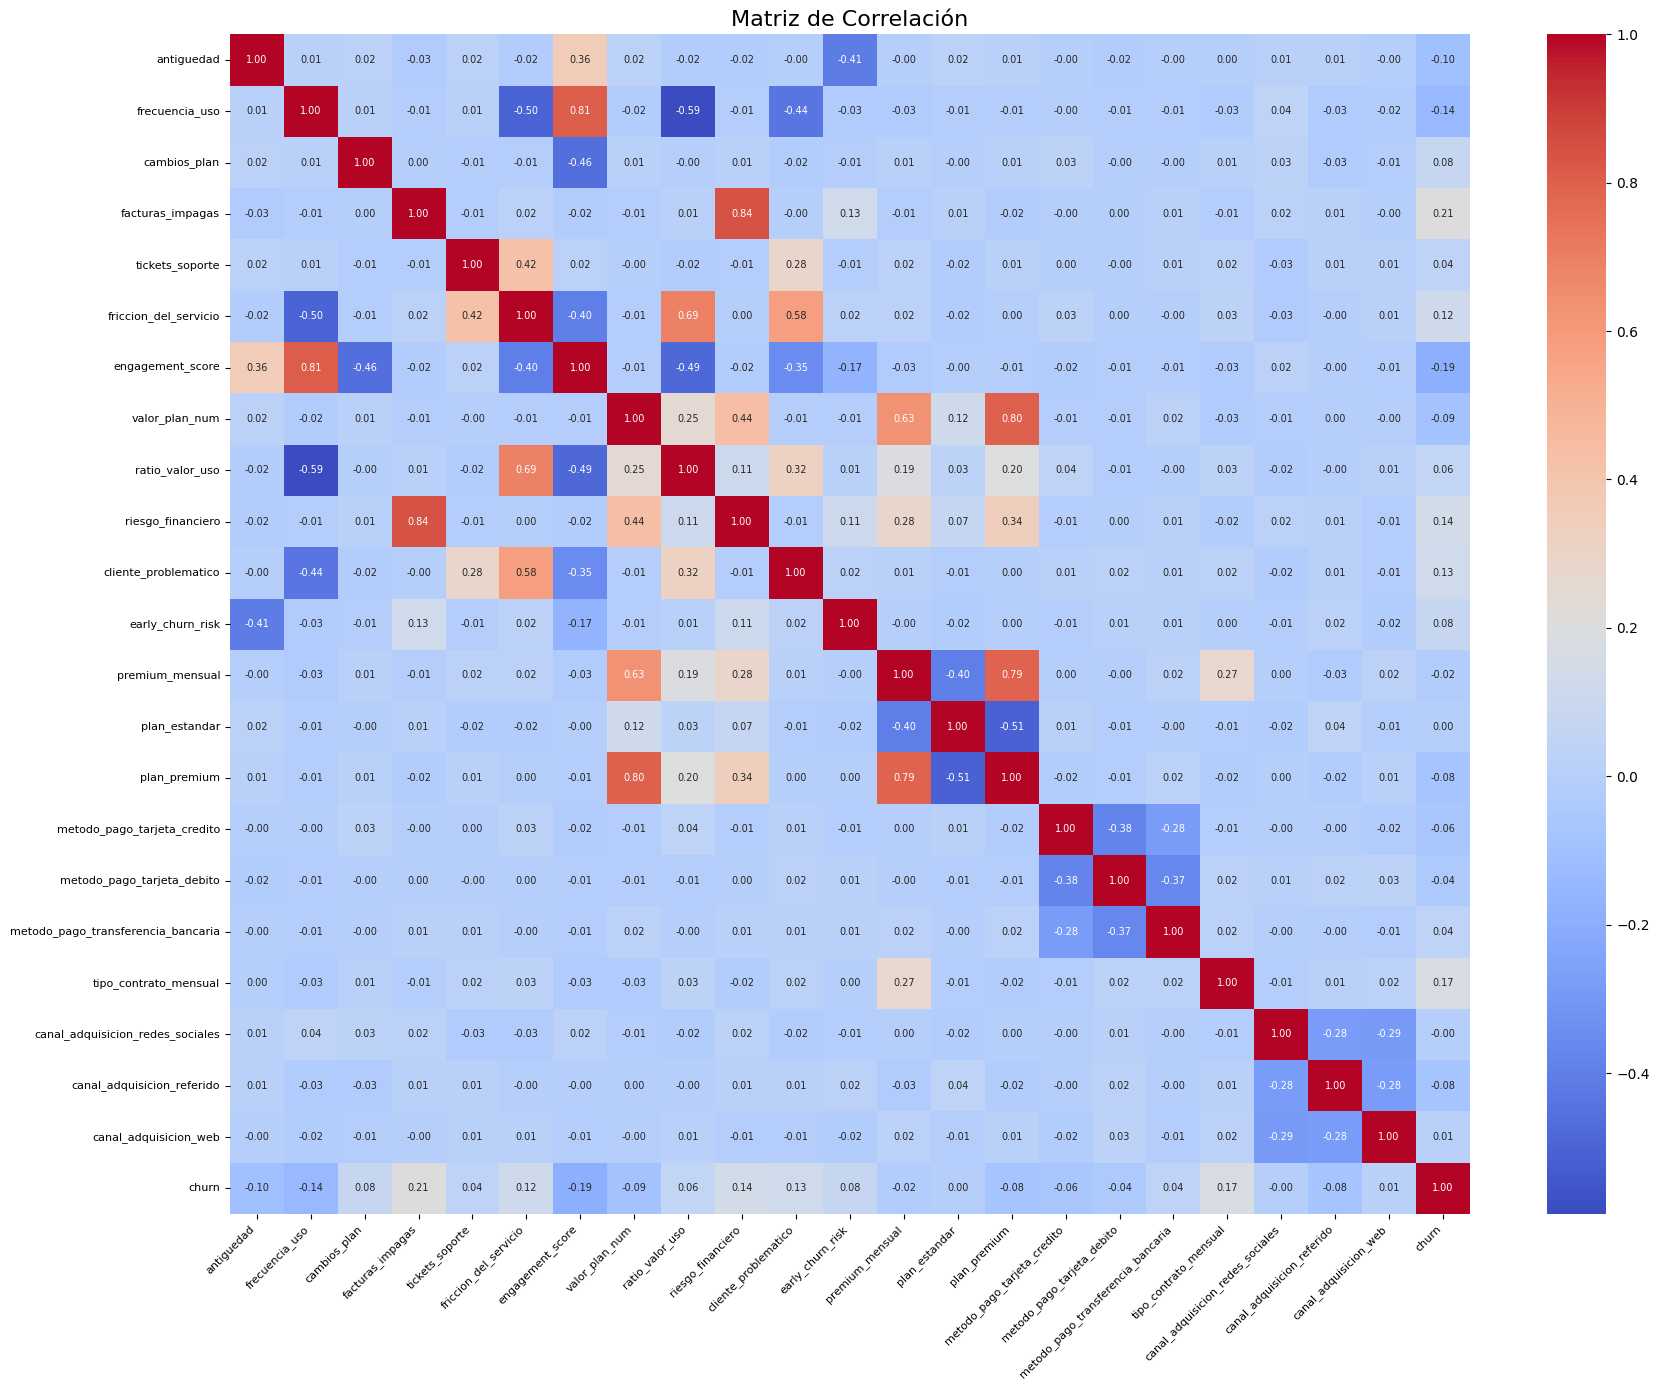

/tmp/ipython-input-408209219.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


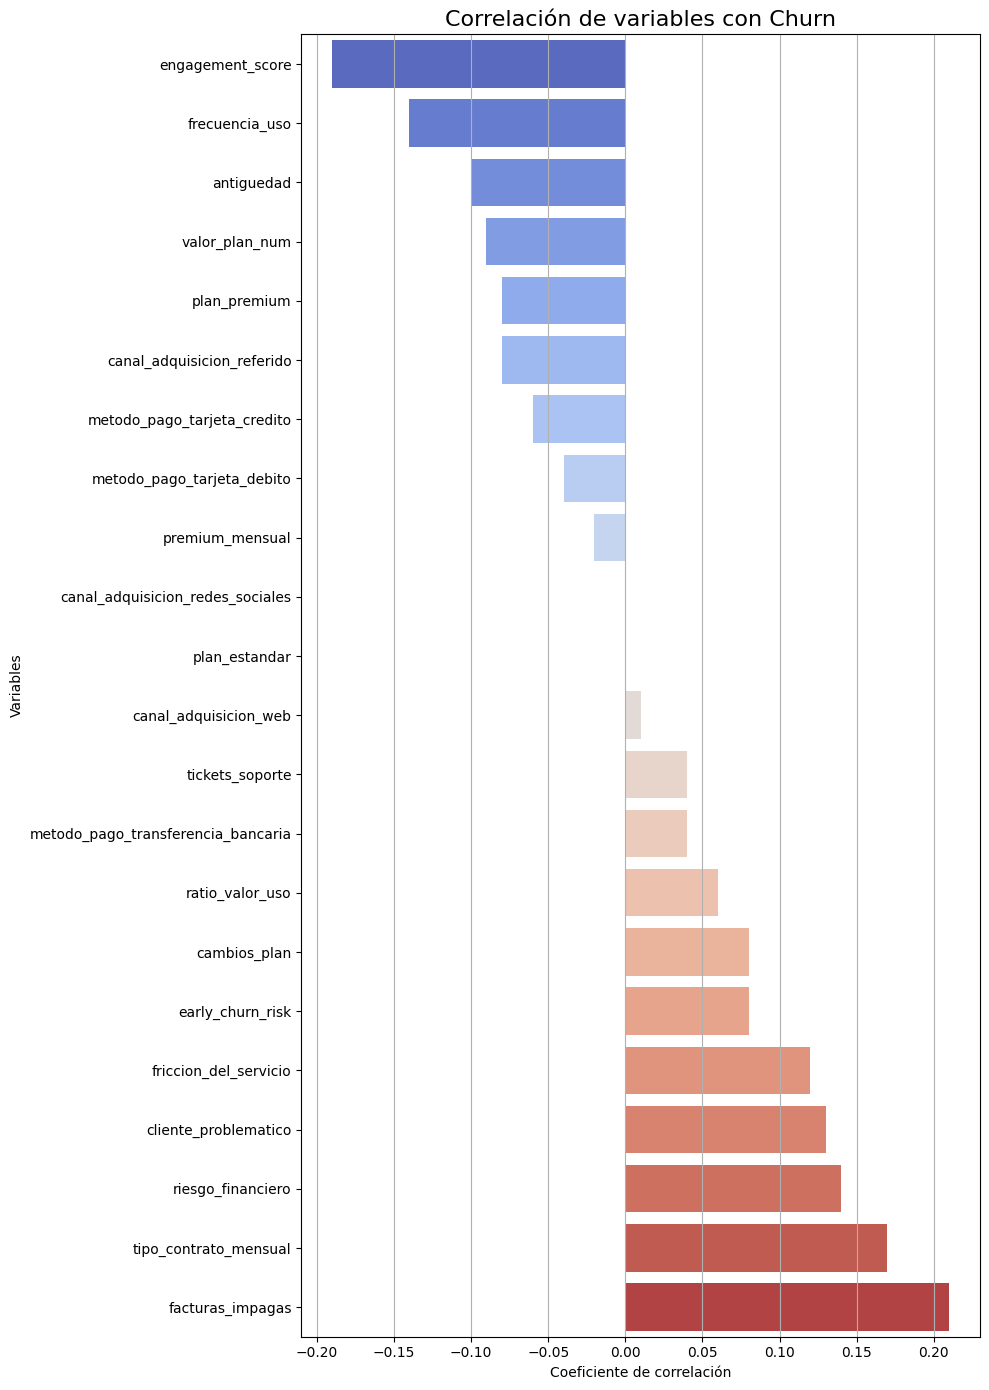

In [495]:
# Analisis de correlación y multicolinearidad

corr = df_codificado.corr().round(2)

plt.figure(figsize=(18, 14))  # definimos el tamaño de figura
sns.heatmap(corr,
            annot=True,         # mostramos los valores de correlación dentro de cada celda
            fmt=".2f",
            cmap='coolwarm',    # paleta de colores
            annot_kws={"size": 7})  # reducimos el tamaño del texto dentro de las celdas

plt.xticks(rotation=45, ha='right', fontsize=8)  # rotamos y achicamos los ticks del eje x
plt.yticks(fontsize=8)                           # tamaño de fuente de los ticks del eje y
plt.title("Matriz de Correlación", fontsize=16)
plt.tight_layout()
plt.show()

# Visualizando mejor las correlaciones con la variable Churn

corr = corr.drop(index='churn').sort_values(by='churn', ascending=True)

plt.figure(figsize=(10, 14))
sns.barplot(
    x='churn',
    y=corr.index,
    data=corr,
    palette='coolwarm'
)
plt.title("Correlación de variables con Churn", fontsize=16)
plt.xlabel("Coeficiente de correlación")
plt.ylabel("Variables")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# 6. Analisis VIF

In [496]:
# variables explicativas
X = df.drop(columns='churn')

# agregar constante
X_const = add_constant(X)

In [497]:
# calcular vif

# Usar el DataFrame codificado para calcular el VIF
X_vif = df_codificado.drop(columns='churn')

# agregar constante
X_vif_const = add_constant(X_vif)

vif_df = pd.DataFrame()
vif_df['feature'] = X_vif_const.columns
vif_df['vif'] = [
    variance_inflation_factor(X_vif_const.values, i)
    for i in range(X_vif_const.shape[1])
]

print(vif_df)

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                               feature        vif
0                                const   0.000000
1                           antiguedad        inf
2                       frecuencia_uso        inf
3                         cambios_plan        inf
4                     facturas_impagas   8.287030
5                      tickets_soporte   1.639152
6                friccion_del_servicio   4.105848
7                     engagement_score        inf
8                       valor_plan_num        inf
9                      ratio_valor_uso   3.437736
10                   riesgo_financiero  10.300741
11                cliente_problematico   1.699951
12                    early_churn_risk   1.220216
13                     premium_mensual   3.446582
14                       plan_estandar        inf
15                        plan_premium        inf
16         metodo_pago_tarjeta_credito   1.552274
17          metodo_pago_tarjeta_debito   1.658554
18  metodo_pago_transferencia_bancaria   1.542994


#### a) Al hacer el analisis de multicolinearidad, asi como el calculo del VIF, se observo que las features 'engagement_score', 'valor_plan_num' y 'riesgo_financiero' son las mas propensas a sesgar el modelo.

In [498]:
columnas_a_eliminar = ['engagement_score', 'valor_plan_num', 'riesgo_financiero']

In [499]:
X_vif_const = X_vif_const.drop(columns=columnas_a_eliminar)

In [500]:
# Analizando nuevamente el VIF sin las columnas mas 'problematicas'
vif_df = pd.DataFrame()
vif_df['feature'] = X_vif_const.columns
vif_df['vif'] = [
    variance_inflation_factor(X_vif_const.values, i)
    for i in range(X_vif_const.shape[1])
]

print(vif_df)

                               feature        vif
0                                const  26.887523
1                           antiguedad   1.200901
2                       frecuencia_uso   1.793841
3                         cambios_plan   1.003602
4                     facturas_impagas   1.020173
5                      tickets_soporte   1.638814
6                friccion_del_servicio   4.103902
7                      ratio_valor_uso   3.437603
8                 cliente_problematico   1.699747
9                     early_churn_risk   1.220210
10                     premium_mensual   3.445892
11                       plan_estandar   1.453716
12                        plan_premium   3.723671
13         metodo_pago_tarjeta_credito   1.551551
14          metodo_pago_tarjeta_debito   1.657355
15  metodo_pago_transferencia_bancaria   1.542540
16               tipo_contrato_mensual   1.287885
17    canal_adquisicion_redes_sociales   1.297598
18          canal_adquisicion_referido   1.296241


### Todas las features muestran un VIF inferior a 5, indicando que no hay una multicolinearidad fuerte.

In [501]:
# Eliminamos las features 'problematicas' del df

df_codificado = df_codificado.drop(columns=columnas_a_eliminar)

df_codificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251 entries, 0 to 4250
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   antiguedad                          4251 non-null   int64  
 1   frecuencia_uso                      4251 non-null   int64  
 2   cambios_plan                        4251 non-null   int64  
 3   facturas_impagas                    4251 non-null   int64  
 4   tickets_soporte                     4251 non-null   int64  
 5   friccion_del_servicio               4251 non-null   float64
 6   ratio_valor_uso                     4251 non-null   float64
 7   cliente_problematico                4251 non-null   int64  
 8   early_churn_risk                    4251 non-null   int64  
 9   premium_mensual                     4251 non-null   int64  
 10  plan_estandar                       4251 non-null   float64
 11  plan_premium                        4251 no

In [502]:
# Selección de las variables explicativas y objetivo

X = df_codificado.drop(columns='churn')
y = df_codificado['churn']

# 7. Modelo de Regresión Logistica CON SMOTE

In [503]:
# Balanceo de clases y normalización
oversample = SMOTE(random_state=82)
normalizacion = MinMaxScaler()

In [504]:
# Separación de datos

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=82, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=82)

In [505]:
# Balanceo de clases

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [506]:
# Normalización

X_train_normalize = normalizacion.fit_transform(X_train_smote)
X_test_normalize = normalizacion.transform(X_test)
X_val_normalize = normalizacion.transform(X_val)

In [507]:
# Creando el modelo

modelo_lr = LogisticRegression(max_iter=1000, random_state=82)

modelo_lr.fit(X_train_normalize, y_train_smote)

LogisticRegression(max_iter=1000, random_state=82)

In [508]:
# Validación cruzada
def intervalo_confianza(validacion, nombreModelo):
  promedio = validacion.mean()
  std = validacion.std()
  return f'intervalo de confianza, modelo {nombreModelo}: [{promedio - (2*std)}, {min((promedio + (2*std)), 1)}]'

stratkf = StratifiedKFold(n_splits=5, random_state=82, shuffle=True)

pipeline = Pipeline([('oversample', SMOTE()), ('lr', modelo_lr)])
validacion = cross_val_score(pipeline, X_temp, y_temp, cv=stratkf, scoring='recall')
print(intervalo_confianza(validacion, 'lr'))

intervalo de confianza, modelo lr: [0.5325327547048191, 0.7584875437223888]


In [509]:
print(modelo_lr.score(X_train_normalize, y_train_smote))
print(modelo_lr.score(X_test_normalize, y_test))

0.6854679802955665
0.6580493537015276


In [510]:
# Metricas de evaluación

def calcularMetricas(y_true ,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  metricas = {'Accuracy': round(accuracy, 4),
              'F1': round(f1, 4),
              'Recall': round(recall, 4),
              'Precision': round(precision, 4)}
  return metricas

  # Matriz de confusión
def matriz_confusion(y_true, y_pred):
  matriz = confusion_matrix(y_true, y_pred)
  visualizer = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['No desertó', 'Desertó'])
  return visualizer.plot()

{'Accuracy': 0.6838, 'F1': 0.5316, 'Recall': 0.7052, 'Precision': 0.4266}


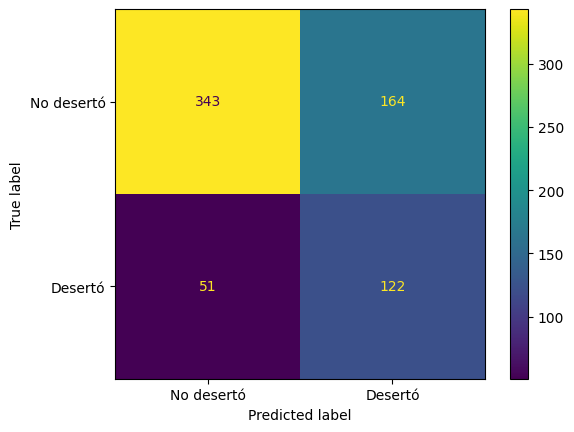

In [511]:
y_pred = modelo_lr.predict(X_val_normalize)
print(calcularMetricas(y_val ,y_pred))

visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Feature importances

In [512]:
# Convertimos X_train_smote y X_val a df para seleccionar las features
X_train_norm_df = pd.DataFrame(X_train_normalize, columns=df_codificado.drop(columns='churn', axis=1).columns)
X_val_norm_df = pd.DataFrame(X_val_normalize, columns=df_codificado.drop(columns='churn', axis=1).columns)

importancias_lr = pd.DataFrame({
    'Features': X_train_norm_df.columns,
    'Coeficiente': modelo_lr.coef_[0],
    'Importancia': np.abs(modelo_lr.coef_[0])
}).sort_values('Importancia', ascending=False)

print(importancias_lr)


importancias_lr['Importancia_%'] = (
    importancias_lr['Importancia'] / importancias_lr['Importancia'].sum() * 100
).round(2)

importancias_lr = importancias_lr.sort_values('Importancia_%', ascending=False)

model_features = LogisticRegression(max_iter=1000, random_state=82)

resultados = pd.DataFrame(index=['Accuracy', 'F1', 'Recall', 'Precision'])

ct_features = [i for i in range(1, 19)]

for i in ct_features:
    selected_features = importancias_lr['Features'].values[:i]
    X_train_sel = X_train_norm_df[selected_features]
    X_val_sel = X_val_norm_df[selected_features]

    model_features.fit(X_train_sel, y_train_smote)
    y_previsto = model_features.predict(X_val_sel)

    metricas = calcularMetricas(y_val, y_previsto)
    resultados[i] = list(metricas.values())

print(resultados)


                              Features  Coeficiente  Importancia
9                      premium_mensual    -1.987238     1.987238
15               tipo_contrato_mensual     1.437549     1.437549
0                           antiguedad    -1.409305     1.409305
3                     facturas_impagas     1.350336     1.350336
1                       frecuencia_uso    -1.119713     1.119713
4                      tickets_soporte    -0.985328     0.985328
5                friccion_del_servicio     0.968233     0.968233
17          canal_adquisicion_referido    -0.793010     0.793010
12         metodo_pago_tarjeta_credito    -0.725628     0.725628
13          metodo_pago_tarjeta_debito    -0.547638     0.547638
6                      ratio_valor_uso    -0.499830     0.499830
18               canal_adquisicion_web    -0.445430     0.445430
11                        plan_premium     0.420285     0.420285
16    canal_adquisicion_redes_sociales    -0.353719     0.353719
10                       

### En este caso, se optara por seleccionar las **5 mejores features**

### Segmentando con las mejores features

In [513]:
lr_features = importancias_lr['Features'].values[:5]

X_selected_features = df_codificado[lr_features]

print(lr_features)

['premium_mensual' 'tipo_contrato_mensual' 'antiguedad' 'facturas_impagas'
 'frecuencia_uso']


In [514]:
# segmentando nuevamente los datos con las mejores features
X_temp, X_test, y_temp, y_test = train_test_split(X_selected_features, y, stratify=y, random_state=82, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, random_state=82, test_size=0.2)

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)


X_train_normalize = normalizacion.fit_transform(X_train_smote)
X_val_normalize = normalizacion.transform(X_val)
X_test_normalize = normalizacion.transform(X_test)

## Optimización de hiperparametros

{'C': 0.01, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
{'Accuracy': 0.4809, 'F1': 0.4406, 'Recall': 0.8035, 'Precision': 0.3035}


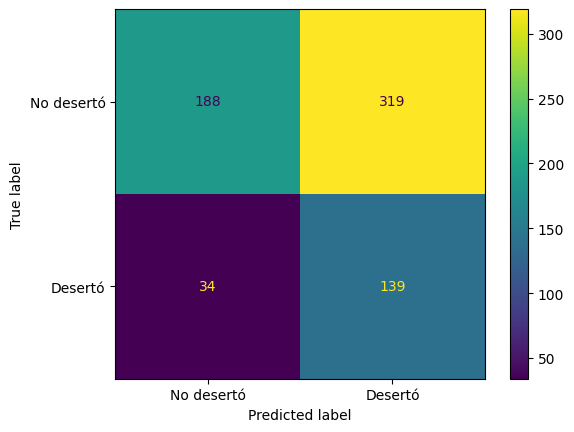

In [515]:
# Grilla de hiperparametros
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None],
    'max_iter': [1000]
}



grid_lr = GridSearchCV(LogisticRegression(random_state=82), param_grid_lr, cv=stratkf, scoring='recall')
grid_lr.fit(X_train_normalize, y_train_smote)

print(grid_lr.best_params_)

# Eligiendo el mejor modelo
best_lr = grid_lr.best_estimator_

best_lr.fit(X_train_normalize, y_train_smote)

# Analisis de metricas
y_pred = best_lr.predict(X_val_normalize)
print(calcularMetricas(y_val, y_pred))
visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Curva ROC y PR

0.6348234542987766


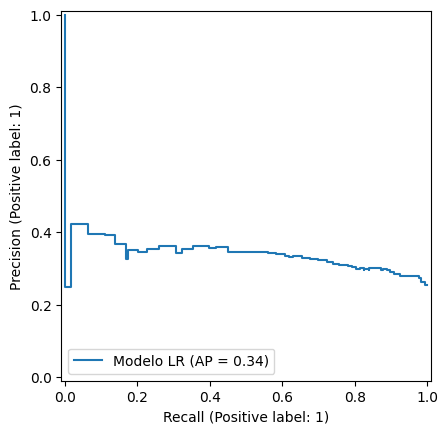

In [516]:
y_pred = best_lr.predict_proba(X_val_normalize)

roc_auc = roc_auc_score(y_val, y_pred[:, 1])
print(roc_auc)
PrecisionRecallDisplay.from_predictions(y_val, y_pred[:, 1], name='Modelo LR')
plt.show()

## Eligiendo el umbral

In [517]:
y_proba = best_lr.predict_proba(X_val_normalize)[:, 1]

In [518]:
y_proba.min(), y_proba.max()

(np.float64(0.4425360762971108), np.float64(0.5548763387120605))

In [519]:
thresholds = np.arange(0.4, 0.66, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.40,0.254412,1.000000,0.405627,680
1,0.41,0.254412,1.000000,0.405627,680
2,0.42,0.254412,1.000000,0.405627,680
3,0.43,0.254412,1.000000,0.405627,680
4,0.44,0.254412,1.000000,0.405627,680
5,0.45,0.263482,0.988439,0.416058,649
6,0.46,0.273752,0.982659,0.428212,621
7,0.47,0.279661,0.953757,0.432503,590
8,0.48,0.290203,0.907514,0.439776,541
9,0.49,0.300797,0.872832,0.447407,502


### **Umbral optimo**: 0.5



## Calibrando las probabilidades

In [520]:
lr_calibrado = CalibratedClassifierCV(
    estimator=best_lr,
    method="sigmoid",
    cv=5
)

In [521]:
lr_calibrado.fit(X_train_normalize, y_train_smote)

CalibratedClassifierCV(cv=5,
                       estimator=LogisticRegression(C=0.01, max_iter=1000,
                                                    penalty='l1',
                                                    random_state=82,
                                                    solver='liblinear'))

In [522]:
y_proba_cal = lr_calibrado.predict_proba(X_val)[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [523]:
y_proba_cal.min(), y_proba_cal.max()

(np.float64(0.24510252171870506), np.float64(0.5751346374834236))

In [524]:
thresholds = np.linspace(y_proba_cal.min(), y_proba_cal.max(), 20)

rows = []

for t in thresholds:
    y_pred = (y_proba_cal >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.245103,0.254412,1.000000,0.405627,680
1,0.262473,0.301811,0.867052,0.447761,497
2,0.279843,0.297741,0.838150,0.439394,487
3,0.297213,0.296066,0.826590,0.435976,483
4,0.314583,0.293750,0.815029,0.431853,480
5,0.331953,0.295597,0.815029,0.433846,477
6,0.349323,0.295597,0.815029,0.433846,477
7,0.366693,0.295597,0.815029,0.433846,477
8,0.384063,0.295597,0.815029,0.433846,477
9,0.401434,0.295597,0.815029,0.433846,477


In [525]:
thresholds = np.arange(0.2, 0.6, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba_cal >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.20,0.254412,1.000000,0.405627,680
1,0.21,0.254412,1.000000,0.405627,680
2,0.22,0.254412,1.000000,0.405627,680
3,0.23,0.254412,1.000000,0.405627,680
4,0.24,0.254412,1.000000,0.405627,680
5,0.25,0.295238,0.895954,0.444126,525
6,0.26,0.300797,0.872832,0.447407,502
7,0.27,0.296524,0.838150,0.438066,489
8,0.28,0.297741,0.838150,0.439394,487
9,0.29,0.296066,0.826590,0.435976,483


### **Umbral optimo**: 0.4

In [526]:
umbral_lr_cal = 0.4

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


{'Accuracy': 0.4888, 'F1': 0.4556, 'Recall': 0.8426, 'Precision': 0.3122}


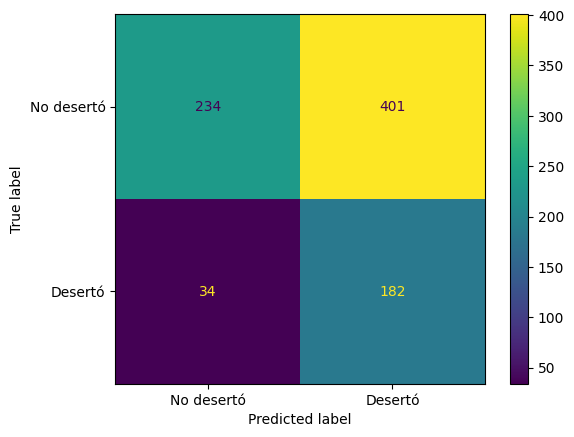

In [527]:
# Testing con el conjunto de prueba
y_proba = lr_calibrado.predict_proba(X_test)[:, 1]

y_pred = (y_proba >= umbral_lr_cal).astype(int)

# Metricas
print(calcularMetricas(y_test, y_pred))

# Matriz de confusión
visualizer = matriz_confusion(y_test, y_pred)
plt.show()

## Curva ROC y PR Post-Calibración

0.6347094435133563


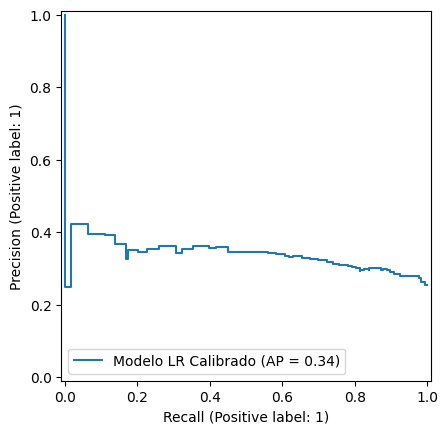

In [528]:
y_pred = lr_calibrado.predict_proba(X_val_normalize)
roc_auc = roc_auc_score(y_val, y_pred[:, 1])
print(roc_auc)

PrecisionRecallDisplay.from_predictions(y_val, y_pred[:, 1], name='Modelo LR Calibrado')
plt.show()

## Nombre de los modelos:

Modelo sin calibrar: **best_lr**

Modelo calibrado: **lr_calibrado**

#8. Modelo Regresión Logistica SIN SMOTE

In [529]:
# Separación de datos

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=82, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=82)

In [530]:
# Normalización

X_train_normalize = normalizacion.fit_transform(X_train)
X_test_normalize = normalizacion.transform(X_test)
X_val_normalize = normalizacion.transform(X_val)

In [531]:
# Creando el modelo

modelo_lr = LogisticRegression(max_iter=1000, random_state=82, class_weight='balanced')

modelo_lr.fit(X_train_normalize, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=82)

In [532]:
# Validación cruzada

pipeline = Pipeline([('lr', modelo_lr)])
validacion = cross_val_score(pipeline, X_temp, y_temp, cv=stratkf, scoring='recall')
print(intervalo_confianza(validacion, 'lr'))

intervalo de confianza, modelo lr: [0.5769088528691846, 0.7603676627915223]


In [533]:
print(modelo_lr.score(X_train_normalize, y_train))
print(modelo_lr.score(X_test_normalize, y_test))

0.6680147058823529
0.6827262044653349


## Metricas de evaluación/ Matriz de confusión

{'Accuracy': 0.6691, 'F1': 0.5055, 'Recall': 0.6647, 'Precision': 0.4078}


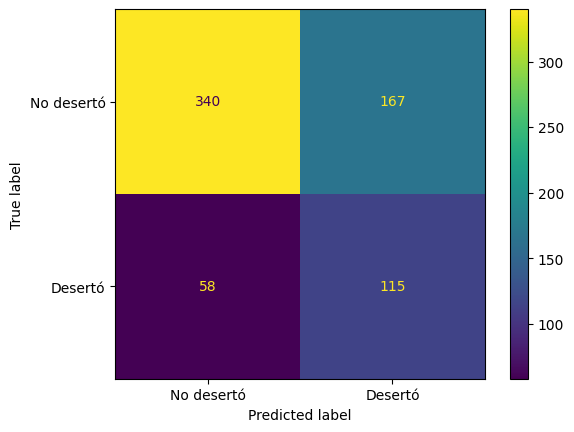

In [534]:
y_pred = modelo_lr.predict(X_val_normalize)
print(calcularMetricas(y_val ,y_pred))

visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Feature Importances

In [535]:
# Convertimos X_train_smote y X_val a df para seleccionar las features
X_train_norm_df = pd.DataFrame(X_train_normalize, columns=df_codificado.drop(columns='churn', axis=1).columns)
X_val_norm_df = pd.DataFrame(X_val_normalize, columns=df_codificado.drop(columns='churn', axis=1).columns)

importancias_lr = pd.DataFrame({
    'Features': X_train_norm_df.columns,
    'Coeficiente': modelo_lr.coef_[0],
    'Importancia': np.abs(modelo_lr.coef_[0])
}).sort_values('Importancia', ascending=False)

print(importancias_lr)


importancias_lr['Importancia_%'] = (
    importancias_lr['Importancia'] / importancias_lr['Importancia'].sum() * 100
).round(2)

importancias_lr = importancias_lr.sort_values('Importancia_%', ascending=False)


print(importancias_lr)

model_features = LogisticRegression(max_iter=1000, random_state=82, class_weight='balanced')

resultados = pd.DataFrame(index=['Accuracy', 'F1', 'Recall', 'Precision'])

ct_features = [i for i in range(1, 19)]
resultados = pd.DataFrame(index=['Accuracy', 'F1', 'Recall', 'Precision'])

for i in ct_features:
    selected_features = importancias_lr['Features'].values[:i]
    X_train_sel = X_train_norm_df[selected_features]
    X_val_sel = X_val_norm_df[selected_features]

    model_features.fit(X_train_sel, y_train)
    y_previsto = model_features.predict(X_val_sel)

    metricas = calcularMetricas(y_val, y_previsto)
    resultados[i] = list(metricas.values())

print(resultados)


                              Features  Coeficiente  Importancia
3                     facturas_impagas     1.752330     1.752330
0                           antiguedad    -1.265493     1.265493
15               tipo_contrato_mensual     1.098458     1.098458
1                       frecuencia_uso    -0.898859     0.898859
2                         cambios_plan     0.723539     0.723539
11                        plan_premium    -0.630916     0.630916
17          canal_adquisicion_referido    -0.609249     0.609249
12         metodo_pago_tarjeta_credito    -0.606765     0.606765
7                 cliente_problematico     0.597304     0.597304
13          metodo_pago_tarjeta_debito    -0.453892     0.453892
4                      tickets_soporte    -0.333367     0.333367
16    canal_adquisicion_redes_sociales    -0.271654     0.271654
18               canal_adquisicion_web    -0.221822     0.221822
10                       plan_estandar    -0.174282     0.174282
5                friccion

### Segmentando con las **7 mejores features**

In [536]:
lr_features = importancias_lr['Features'].values[:7]

X_selected_features = df_codificado[lr_features]

print(lr_features)

['facturas_impagas' 'antiguedad' 'tipo_contrato_mensual' 'frecuencia_uso'
 'cambios_plan' 'plan_premium' 'canal_adquisicion_referido']


In [537]:
# segmentando nuevamente los datos con las mejores features
X_temp, X_test, y_temp, y_test = train_test_split(X_selected_features, y, stratify=y, random_state=82, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, random_state=82, test_size=0.2)


X_train_normalize = normalizacion.fit_transform(X_train)
X_val_normalize = normalizacion.transform(X_val)
X_test_normalize = normalizacion.transform(X_test)

## Optimización de hiperparametros

{'C': 0.01, 'class_weight': {0: 1, 1: 3}, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
{'Accuracy': 0.5456, 'F1': 0.4976, 'Recall': 0.8844, 'Precision': 0.3462}


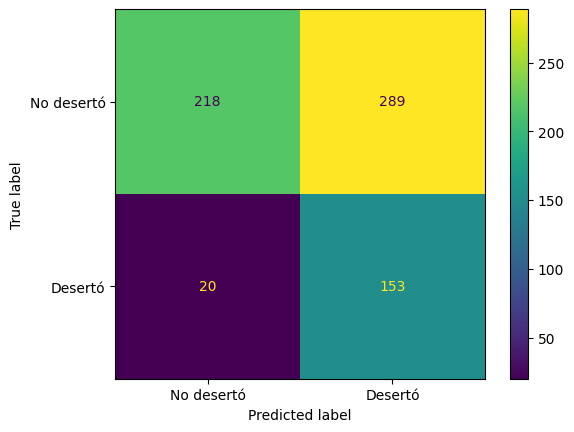

In [538]:
# Grilla de hiperparametros
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [
    'balanced',
    {0: 1, 1: 2},
    {0: 1, 1: 3}
    ],
    'max_iter': [200, 500, 1000]
}


grid_lr = GridSearchCV(LogisticRegression(random_state=82), param_grid_lr, cv=stratkf, scoring='recall')
grid_lr.fit(X_train_normalize, y_train)

print(grid_lr.best_params_)

# Eligiendo el mejor modelo
best_lr_no_smote = grid_lr.best_estimator_

best_lr_no_smote.fit(X_train_normalize, y_train)

# Analisis de metricas
y_pred = best_lr_no_smote.predict(X_val_normalize)
print(calcularMetricas(y_val, y_pred))
visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Eligiendo el umbral optimo

In [539]:
y_proba = best_lr_no_smote.predict_proba(X_val_normalize)[:, 1]

In [540]:
y_proba.min(), y_proba.max()

(np.float64(0.4190711803628839), np.float64(0.6009936138394746))

In [541]:
thresholds = np.arange(0.4, 0.6, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.40,0.254412,1.000000,0.405627,680
1,0.41,0.254412,1.000000,0.405627,680
2,0.42,0.255917,1.000000,0.407538,676
3,0.43,0.257440,1.000000,0.409467,672
4,0.44,0.258982,1.000000,0.411415,668
5,0.45,0.265337,1.000000,0.419394,652
6,0.46,0.271586,1.000000,0.427160,637
7,0.47,0.286190,0.994220,0.444444,601
8,0.48,0.297834,0.953757,0.453920,554
9,0.49,0.323108,0.913295,0.477341,489


### Umbral optimo: **0.52**

## Calibrando las probabilidades

In [542]:
lr_calibrado_no_smote = CalibratedClassifierCV(
    estimator=best_lr_no_smote,
    method="sigmoid",
    cv=5
)

In [543]:
# Entrenando el calibrador
lr_calibrado_no_smote.fit(X_train_normalize, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=LogisticRegression(C=0.01,
                                                    class_weight={0: 1, 1: 3},
                                                    max_iter=200, penalty='l1',
                                                    random_state=82,
                                                    solver='liblinear'))

In [544]:
y_proba_cal = lr_calibrado_no_smote.predict_proba(X_val)[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [545]:
y_proba_cal.min(), y_proba_cal.max()

(np.float64(0.027465212751049805), np.float64(0.9491977001007996))

In [546]:
thresholds = np.linspace(y_proba_cal.min(), y_proba_cal.max(), 20)

rows = []

for t in thresholds:
    y_pred = (y_proba_cal >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.027465,0.254412,1.000000,0.405627,680
1,0.075977,0.306084,0.930636,0.460658,526
2,0.124490,0.307992,0.913295,0.460641,513
3,0.173002,0.326360,0.901734,0.479263,478
4,0.221514,0.340050,0.780347,0.473684,397
5,0.270026,0.337696,0.745665,0.464865,382
6,0.318539,0.336000,0.728324,0.459854,375
7,0.367051,0.365385,0.658960,0.470103,312
8,0.415563,0.383178,0.473988,0.423773,214
9,0.464075,0.379085,0.335260,0.355828,153


In [547]:
thresholds = np.arange(0.12, 0.3, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba_cal >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.12,0.307992,0.913295,0.460641,513
1,0.13,0.307992,0.913295,0.460641,513
2,0.14,0.307992,0.913295,0.460641,513
3,0.15,0.311637,0.913295,0.464706,507
4,0.16,0.321138,0.913295,0.475188,492
5,0.17,0.325678,0.901734,0.478528,479
6,0.18,0.328421,0.901734,0.481481,475
7,0.19,0.331210,0.901734,0.484472,471
8,0.20,0.340858,0.872832,0.490260,443
9,0.21,0.339806,0.809249,0.478632,412


### Umbral optimo: **0.20**

In [548]:
umbral_lr_cal = 0.2

In [549]:
# Test con el conjunto de prueba

y_proba = lr_calibrado_no_smote.predict_proba(X_test)[:, 1]

y_pred = (y_proba >= umbral_lr_cal).astype(int)

print(calcularMetricas(y_test, y_pred))

{'Accuracy': 0.5018, 'F1': 0.4687, 'Recall': 0.8657, 'Precision': 0.3213}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Nombre de los modelos:

Modelo sin calibrar: **best_lr_no_smote**

Modelo calibrado: **lr_calibrado_no_smote**

#9. Modelo RandomForest

In [550]:
# Separación de datos
X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, random_state=82, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, random_state=82, test_size=0.2)

In [551]:
# Balanceo de clases

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [552]:
# Creando el modelo
modelo_forest = RandomForestClassifier(random_state=82, n_estimators=100, min_samples_leaf=3, min_samples_split=5, max_depth=5)

modelo_forest.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=5,
                       random_state=82)

## Analisis de metricas / Matriz de confusión

In [553]:
pipeline = Pipeline([('oversample', SMOTE()), ('xgb', modelo_forest)])
validacion = cross_val_score(pipeline, X_temp, y_temp, cv=stratkf, scoring='recall')
print(intervalo_confianza(validacion, 'forest'))

intervalo de confianza, modelo forest: [0.3438815064065509, 0.5483620747199445]


In [554]:
y_pred = modelo_forest.predict(X_val)
metricasForest = calcularMetricas(y_val, y_pred)

print(metricasForest)

{'Accuracy': 0.7382, 'F1': 0.4639, 'Recall': 0.4451, 'Precision': 0.4843}


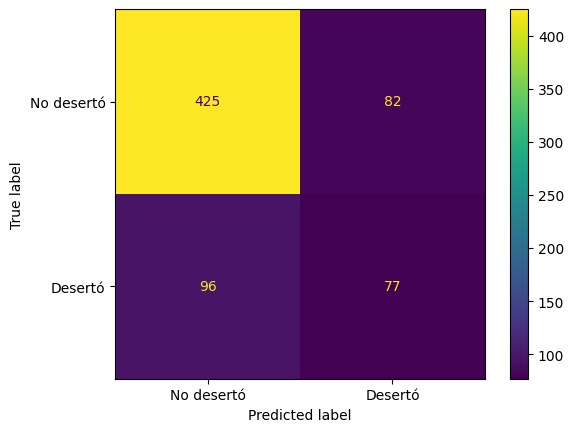

In [555]:
visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Optimización de parametros

In [556]:
scorer = make_scorer(recall_score)

In [557]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [558]:
random_search = RandomizedSearchCV(
    estimator=modelo_forest,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scorer,
    cv=5,
    verbose=2,
    random_state=82,
    n_jobs=-1
)

In [559]:
random_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=5,
                                                    min_samples_leaf=3,
                                                    min_samples_split=5,
                                                    random_state=82),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=82,
                   scoring=make_scorer(recall_score, response_method='predict'),
                   verbose=2)

In [560]:
# Viendo los mejores parametros
random_search.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 5,
 'bootstrap': True}

In [561]:
# Seleccionando el mejor estimador
best_rf = random_search.best_estimator_

In [562]:
best_rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=2,
                       n_estimators=300, random_state=82)

## Eligiendo el umbral

In [563]:
y_proba = best_rf.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.2, 0.4, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.20,0.284298,0.994220,0.442159,605
1,0.21,0.287145,0.994220,0.445596,599
2,0.22,0.290541,0.994220,0.449673,592
3,0.23,0.297578,0.994220,0.458056,578
4,0.24,0.303887,0.994220,0.465494,566
5,0.25,0.308108,0.988439,0.469780,555
6,0.26,0.305455,0.971098,0.464730,550
7,0.27,0.314501,0.965318,0.474432,531
8,0.28,0.319767,0.953757,0.478955,516
9,0.29,0.325911,0.930636,0.482759,494


### Umbral optimo: **0.39**

In [564]:
umbral_rf = 0.39

In [565]:
y_proba_val = best_rf.predict_proba(X_val)[:, 1]
y_pred = (y_proba_val >= umbral_rf).astype(int)

In [566]:
print(calcularMetricas(y_val, y_pred))

{'Accuracy': 0.6691, 'F1': 0.5303, 'Recall': 0.7341, 'Precision': 0.415}


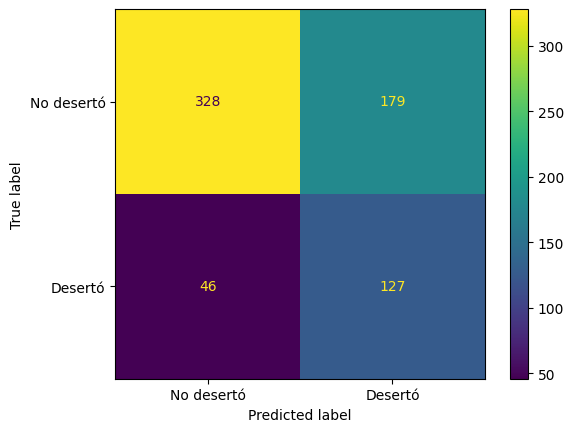

In [567]:
visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Feature Importances + Feature Selection

In [568]:
# Convertimos X_train_smote y X_val a df para seleccionar las features
X_train_df = pd.DataFrame(X_train_smote, columns=df_codificado.drop(columns='churn', axis=1).columns)
X_val_df = pd.DataFrame(X_val, columns=df_codificado.drop(columns='churn', axis=1).columns)

importancias = best_rf.feature_importances_
ft_importances = pd.DataFrame({'Features': df_codificado.drop(columns='churn', axis=1).columns,
                               'Importancia': (importancias*100).round(2)}).sort_values('Importancia', ascending=False)

print(ft_importances)

resultados = pd.DataFrame(index=['Accuracy', 'F1', 'Recall', 'Precision'])

ct_features = [i for i in range(1, 19)]

for i in ct_features:

    selected_features = ft_importances['Features'].values[:i]
    X_train_sel = X_train_df[selected_features]
    X_val_sel = X_val_df[selected_features]

    model_features = clone(random_search.best_estimator_)
    model_features.fit(X_train_sel, y_train_smote)

    y_proba = model_features.predict_proba(X_val_sel)[:, 1]
    y_pred_val = (y_proba >= umbral_rf).astype(int)

    metricas = calcularMetricas(y_val, y_pred_val)
    resultados[i] = list(metricas.values())

print(resultados)

                              Features  Importancia
15               tipo_contrato_mensual        23.20
3                     facturas_impagas        13.22
13          metodo_pago_tarjeta_debito        11.30
11                        plan_premium         7.83
17          canal_adquisicion_referido         7.81
12         metodo_pago_tarjeta_credito         6.90
10                       plan_estandar         5.27
14  metodo_pago_transferencia_bancaria         5.10
5                friccion_del_servicio         3.40
1                       frecuencia_uso         3.25
16    canal_adquisicion_redes_sociales         2.62
9                      premium_mensual         2.43
6                      ratio_valor_uso         2.30
0                           antiguedad         2.25
18               canal_adquisicion_web         1.42
4                      tickets_soporte         0.80
2                         cambios_plan         0.51
7                 cliente_problematico         0.26
8           

## Features optimas: 5

In [569]:
rf_features = ft_importances['Features'].values[:5]
rf_features

array(['tipo_contrato_mensual', 'facturas_impagas',
       'metodo_pago_tarjeta_debito', 'plan_premium',
       'canal_adquisicion_referido'], dtype=object)

In [570]:
X_selected_features = df_codificado[rf_features]

## Segmentando con las features optimas

In [571]:
X_temp, X_test, y_temp, y_test = train_test_split(X_selected_features, y, random_state=82, stratify=y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, random_state=82, stratify=y_temp, test_size=0.2)

In [572]:
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [573]:
modelo_rf = clone(random_search.best_estimator_)

In [574]:
modelo_rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=2,
                       n_estimators=300, random_state=82)

## Eligiendo el umbral

In [575]:
y_proba_val = modelo_rf.predict_proba(X_val)[:, 1]

In [576]:
rows = []


thresholds = np.arange(0.3, 0.6, 0.01)

for t in thresholds:
    y_pred = (y_proba_val >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.30,0.329810,0.901734,0.482972,473
1,0.31,0.326964,0.890173,0.478261,471
2,0.32,0.329718,0.878613,0.479495,461
3,0.33,0.329718,0.878613,0.479495,461
4,0.34,0.331140,0.872832,0.480127,456
5,0.35,0.338673,0.855491,0.485246,437
6,0.36,0.345882,0.849711,0.491639,425
7,0.37,0.345882,0.849711,0.491639,425
8,0.38,0.348341,0.849711,0.494118,422
9,0.39,0.347826,0.832370,0.490630,414


### Umbral optimo: **0.52**

In [577]:
umbral_rf = 0.52

In [578]:
y_proba = modelo_rf.predict_proba(X_val)[:, 1]
y_pred = (y_proba >= umbral_rf).astype(int)

In [579]:
print(calcularMetricas(y_val, y_pred))

{'Accuracy': 0.625, 'F1': 0.491, 'Recall': 0.711, 'Precision': 0.375}


## Calibración

In [580]:
rf_calibrado = CalibratedClassifierCV(
    estimator = modelo_rf,
    method = 'sigmoid',
    cv = 5
)

In [581]:
rf_calibrado.fit(X_train_smote, y_train_smote)

CalibratedClassifierCV(cv=5,
                       estimator=RandomForestClassifier(max_depth=5,
                                                        max_features='log2',
                                                        min_samples_leaf=2,
                                                        n_estimators=300,
                                                        random_state=82))

In [582]:
y_proba_cal = rf_calibrado.predict_proba(X_val)[:, 1]

In [583]:
thresholds = np.arange(0.3, 0.6, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba_cal >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.30,0.340278,0.849711,0.485950,432
1,0.31,0.340278,0.849711,0.485950,432
2,0.32,0.342657,0.849711,0.488372,429
3,0.33,0.348341,0.849711,0.494118,422
4,0.34,0.348341,0.849711,0.494118,422
5,0.35,0.348449,0.843931,0.493243,419
6,0.36,0.346535,0.809249,0.485269,404
7,0.37,0.346633,0.803468,0.484321,401
8,0.38,0.346633,0.803468,0.484321,401
9,0.39,0.346633,0.803468,0.484321,401


### Umbral optimo: 0.52

In [584]:
umbral_rf_cal = 0.52

In [585]:
# testing con el conjunto de prueba

y_proba_test = rf_calibrado.predict_proba(X_test)[:, 1]
y_pred = (y_proba_test >= umbral_rf_cal).astype(int)

print(calcularMetricas(y_test, y_pred))

{'Accuracy': 0.6381, 'F1': 0.5096, 'Recall': 0.7407, 'Precision': 0.3883}


#10. Modelo XGBOOST con SMOTE

In [586]:
# Segmentación de datos

X_temp, X_test, y_temp, y_test = train_test_split(X, y, random_state=82, stratify=y, test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, random_state=82, stratify=y_temp, test_size=0.2)

In [587]:
# Balanceo de clases

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [588]:
# Creando el modelo

modelo_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    n_estimators=300,
    learning_rate=0.05,
    random_state=82
)

modelo_xgb.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

## Analisis de metricas / Matriz de confusión

In [589]:
pipeline = Pipeline([('oversample', SMOTE()), ('xgb', modelo_xgb)])
validacion = cross_val_score(pipeline, X_temp, y_temp, cv=stratkf, scoring='recall')
print(intervalo_confianza(validacion, 'xgb'))

intervalo de confianza, modelo xgb: [0.30007410767665227, 0.3418535707747525]


{'Accuracy': 0.7235, 'F1': 0.3562, 'Recall': 0.3006, 'Precision': 0.437}


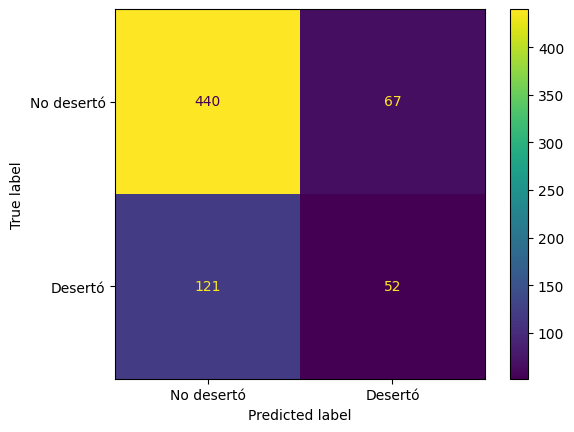

In [590]:
y_pred = modelo_xgb.predict(X_val)
print(calcularMetricas(y_val ,y_pred))

visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Optimización de hiperparametros

In [591]:
param_xgb = {
    "max_depth": [2, 3, 4, 5],
    "min_child_weight": [1, 5, 10],
    "subsample": np.linspace(0.6, 0.9, 4),
    "colsample_bytree": np.linspace(0.6, 0.9, 4)
}

random_search = RandomizedSearchCV(
    estimator=modelo_xgb,
    param_distributions=param_xgb,
    n_iter=30,
    scoring="average_precision",
    cv=5,
    random_state=82,
    n_jobs=-1,
    verbose=1
)

In [592]:
random_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='aucpr',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constr...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=300, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.6, 0.7, 0.8, 0.9]),
                                        'max_depth': [2, 3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': array([0.6, 0.7, 0.8, 0.9])},
                   random_state=82, scoring='average_precision', verbose=1)

In [593]:
# viendo los mejores parametros
random_search.best_params_

{'subsample': np.float64(0.9),
 'min_child_weight': 1,
 'max_depth': 3,
 'colsample_bytree': np.float64(0.6)}

In [594]:
# seleccionando el mejor estimador
best_xgb = random_search.best_estimator_

In [595]:
best_xgb.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.6), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

## Eligiendo el umbral

In [596]:
y_proba = best_xgb.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.2, 0.4, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.20,0.391076,0.861272,0.537906,381
1,0.21,0.388140,0.832370,0.529412,371
2,0.22,0.404494,0.832370,0.544423,356
3,0.23,0.408284,0.797688,0.540117,338
4,0.24,0.412308,0.774566,0.538153,325
5,0.25,0.427184,0.763006,0.547718,309
6,0.26,0.431438,0.745665,0.546610,299
7,0.27,0.432990,0.728324,0.543103,291
8,0.28,0.435540,0.722543,0.543478,287
9,0.29,0.438406,0.699422,0.538976,276


### Umbral optimo: **0.25**

In [597]:
umbral_xgb = 0.25

In [598]:
y_proba_val = best_xgb.predict_proba(X_val)[:, 1]
y_pred_val = (y_proba_val >= umbral_xgb).astype(int)

In [599]:
metricas_val = calcularMetricas(y_val, y_pred_val)
print(metricas_val)

{'Accuracy': 0.6794, 'F1': 0.5477, 'Recall': 0.763, 'Precision': 0.4272}


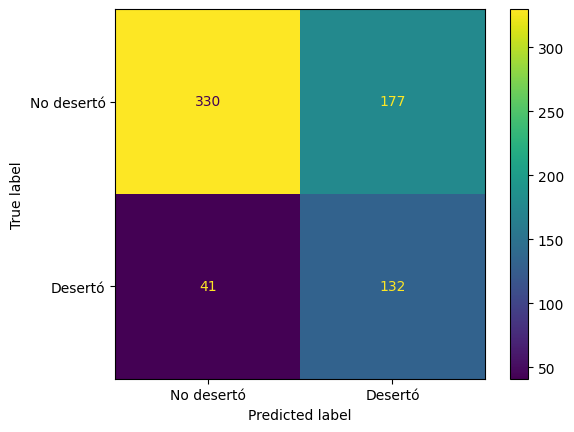

In [600]:
visualizer = matriz_confusion(y_val, y_pred_val)
plt.show()

## Feature Importances + Feature Selection

In [601]:
booster = best_xgb.get_booster()

importancias = booster.get_score(importance_type='gain')

In [602]:
importancias_xgb = (
    pd.DataFrame(importancias.items(), columns=["Feature", "Gain"])
    .sort_values("Gain", ascending=False)
)

In [603]:
importancias_xgb["Gain_%"] = (
    importancias_xgb["Gain"] /
    importancias_xgb["Gain"].sum() * 100
)

In [604]:
importancias_xgb

,Feature,Gain,Gain_%
15,tipo_contrato_mensual,51.376495,14.991109
13,metodo_pago_tarjeta_debito,38.829842,11.330130
11,plan_premium,36.325558,10.599407
17,canal_adquisicion_referido,34.772057,10.146112
12,metodo_pago_tarjeta_credito,25.883718,7.552591
16,canal_adquisicion_redes_sociales,23.010775,6.714297
14,metodo_pago_transferencia_bancaria,22.792025,6.650468
18,canal_adquisicion_web,21.211348,6.189243
3,facturas_impagas,19.940552,5.818439
10,plan_estandar,18.186670,5.306675


In [605]:
# Convertimos X_train_smote y X_val a df para seleccionar las features
X_train_df = pd.DataFrame(X_train_smote, columns=df_codificado.drop(columns='churn', axis=1).columns)
X_val_df = pd.DataFrame(X_val, columns=df_codificado.drop(columns='churn', axis=1).columns)

model_features = random_search.best_estimator_

resultados = pd.DataFrame(index=['Accuracy', 'F1', 'Recall', 'Precision'])

ct_features = [i for i in range(1, 19)]

for i in ct_features:

    selected_features = importancias_xgb['Feature'].values[:i]
    X_train_sel = X_train_df[selected_features]
    X_val_sel = X_val_df[selected_features]

    model_features = clone(random_search.best_estimator_)
    model_features.fit(X_train_sel, y_train_smote)

    y_proba = model_features.predict_proba(X_val_sel)[:, 1]
    y_pred_val = (y_proba >= umbral_xgb).astype(int)

    metricas = calcularMetricas(y_val, y_pred_val)
    resultados[i] = list(metricas.values())

print(resultados)

               1       2       3       4       5       6       7       8   \
Accuracy   0.4588  0.4588  0.5029  0.4059  0.4691  0.5397  0.5294  0.5574   
F1         0.4338  0.4338  0.4441  0.4326  0.4455  0.4704  0.4444  0.4615   
Recall     0.8150  0.8150  0.7803  0.8902  0.8382  0.8035  0.7399  0.7457   
Precision  0.2956  0.2956  0.3103  0.2857  0.3033  0.3325  0.3176  0.3342   

               9       10      11      12      13      14      15      16  \
Accuracy   0.6221  0.6103  0.6162  0.6515  0.6588  0.6676  0.6676  0.6706   
F1         0.5160  0.4991  0.5029  0.5212  0.5323  0.5350  0.5388  0.5391   
Recall     0.7919  0.7630  0.7630  0.7457  0.7630  0.7514  0.7630  0.7572   
Precision  0.3827  0.3708  0.3750  0.4006  0.4087  0.4153  0.4164  0.4185   

               17      18  
Accuracy   0.6779  0.6853  
F1         0.5485  0.5597  
Recall     0.7688  0.7861  
Precision  0.4263  0.4345  


## Features optimas: 6

In [606]:
xgb_features = importancias_xgb['Feature'].values[:6]

In [607]:
X_selected_features = df_codificado[xgb_features]

In [608]:
print(xgb_features)

['tipo_contrato_mensual' 'metodo_pago_tarjeta_debito' 'plan_premium'
 'canal_adquisicion_referido' 'metodo_pago_tarjeta_credito'
 'canal_adquisicion_redes_sociales']


In [609]:
# Segmentando los datos con las mejores features

X_temp, X_test, y_temp, y_test = train_test_split(X_selected_features, y, random_state=82, stratify=y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.2, random_state=82)

In [610]:
# Balanceo de clases

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [611]:
modelo_xgb = clone(random_search.best_estimator_)
modelo_xgb.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.6), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [612]:
y_proba = modelo_xgb.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.3, 0.6, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.30,0.274062,0.971098,0.427481,613
1,0.31,0.274380,0.959538,0.426735,605
2,0.32,0.283713,0.936416,0.435484,571
3,0.33,0.288566,0.919075,0.439227,551
4,0.34,0.294455,0.890173,0.442529,523
5,0.35,0.295146,0.878613,0.441860,515
6,0.36,0.295146,0.878613,0.441860,515
7,0.37,0.297030,0.867052,0.442478,505
8,0.38,0.301811,0.867052,0.447761,497
9,0.39,0.306748,0.867052,0.453172,489


### Umbral optimo: **0.4**

In [613]:
umbral_xgb = 0.4

In [614]:
y_proba_val = modelo_xgb.predict_proba(X_val)[:, 1]

In [615]:
y_pred = (y_proba_val >= umbral_xgb).astype(int)

In [616]:
metricas_val = calcularMetricas(y_val, y_pred)
print(metricas_val)

{'Accuracy': 0.4676, 'F1': 0.4532, 'Recall': 0.8671, 'Precision': 0.3067}


## Calibración

In [617]:
xgb_calibrado = CalibratedClassifierCV(
    estimator=modelo_xgb,
    method='sigmoid',
    cv=5
)

xgb_calibrado.fit(X_train_smote, y_train_smote)

CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=np.float64(0.6),
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='aucpr',
                                               feature_types=None,
                                               feature_weights=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.05, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=3,
                                               max_leaves=None,
                                               min_child_weight=1, missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=300, n_jobs=None,
                                               num_parallel_tree=None, ...))

In [618]:
# Obteniendo las probabilidades calibradas

y_proba_cal = xgb_calibrado.predict_proba(X_val)[:, 1]

In [619]:
thresholds = np.arange(0.3, 0.6, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba_cal >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.30,0.274062,0.971098,0.427481,613
1,0.31,0.283713,0.936416,0.435484,571
2,0.32,0.288566,0.919075,0.439227,551
3,0.33,0.294455,0.890173,0.442529,523
4,0.34,0.295146,0.878613,0.441860,515
5,0.35,0.295146,0.878613,0.441860,515
6,0.36,0.297030,0.867052,0.442478,505
7,0.37,0.306748,0.867052,0.453172,489
8,0.38,0.306748,0.867052,0.453172,489
9,0.39,0.306748,0.867052,0.453172,489


### Umbral optimo: 0.46

In [620]:
umbral_xgb_calibrado = 0.46

In [621]:
# Testing con el conjunto de prueba

y_proba_test = xgb_calibrado.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= umbral_xgb_calibrado).astype(int)

metricas_test = calcularMetricas(y_test, y_pred_test)
print(metricas_test)

{'Accuracy': 0.5182, 'F1': 0.4689, 'Recall': 0.838, 'Precision': 0.3255}


#11. Modelo XGBOOST sin SMOTE ni scale_pos_weight

## Segmentación de datos

In [622]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=82)

In [623]:
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=82)

## Creando y entrenando el modelo base

In [624]:
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    n_estimators=300,
    learning_rate=0.05,
    random_state=82
)

In [625]:
xgb_base.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

## Analisis de metricas / Matriz de confusión

In [626]:
y_pred = xgb_base.predict(X_val)
print(calcularMetricas(y_val, y_pred))

{'Accuracy': 0.7265, 'F1': 0.3542, 'Recall': 0.2948, 'Precision': 0.4435}


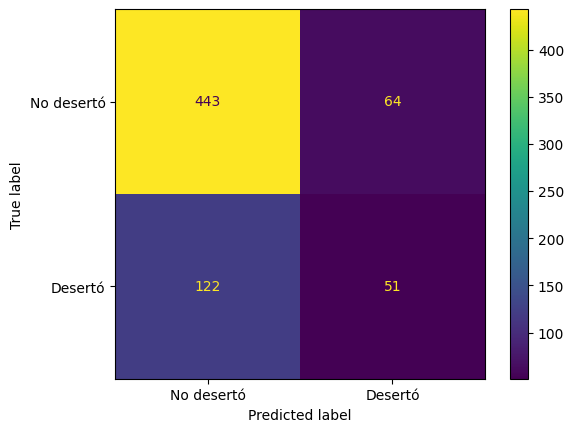

In [627]:
visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Optimización de hiperparametros

In [628]:
param_grid_xgb = {
    'n_estimators': [200, 300, 400, 600],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid_xgb,
    n_iter=30,
    scoring="average_precision",
    cv=5,
    random_state=82,
    n_jobs=-1,
    verbose=1
)

In [629]:
random_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='aucpr',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constr...
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'gamma': [0, 0.1, 0.3, 0.5],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [200, 300, 400, 600],
                                        'reg_alpha': [0, 0.01, 0.1, 1],
                                        'reg_lambda': [1, 1.5, 2, 3],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=82, scoring='average_precision', verbose=1)

In [630]:
# mejores parametros

random_search_xgb.best_params_

{'subsample': 0.8,
 'reg_lambda': 1.5,
 'reg_alpha': 0.01,
 'n_estimators': 200,
 'min_child_weight': 5,
 'max_depth': 3,
 'learning_rate': 0.03,
 'gamma': 0,
 'colsample_bytree': 0.9}

In [631]:
# mejor estimador

best_xgb_sbc = random_search_xgb.best_estimator_

In [632]:
best_xgb_sbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

## Eligiendo el umbral

In [633]:
y_proba = best_xgb_sbc.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.1, 0.3, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.10,0.323810,0.982659,0.487106,525
1,0.11,0.332673,0.971098,0.495575,505
2,0.12,0.337423,0.953757,0.498489,489
3,0.13,0.344609,0.942197,0.504644,473
4,0.14,0.347826,0.924855,0.505529,460
5,0.15,0.350993,0.919075,0.507987,453
6,0.16,0.367681,0.907514,0.523333,427
7,0.17,0.379902,0.895954,0.533563,408
8,0.18,0.390746,0.878613,0.540925,389
9,0.19,0.405405,0.867052,0.552486,370


### Umbral optimo : **0.2**

In [634]:
umbral_xgb_sbc = 0.2

In [635]:
y_pred = (y_proba >= 0.2).astype(int)

In [636]:
print(calcularMetricas(y_val, y_pred))

{'Accuracy': 0.6603, 'F1': 0.56, 'Recall': 0.8497, 'Precision': 0.4176}


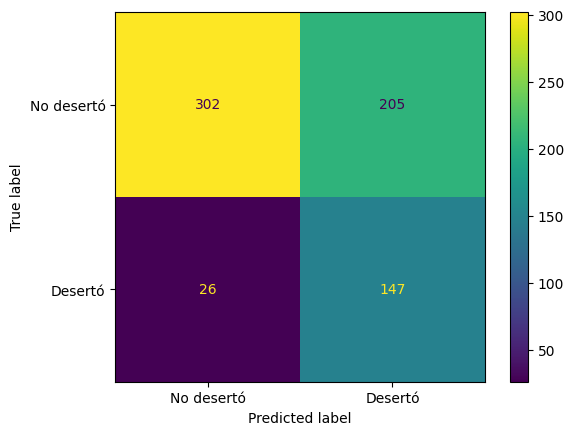

In [637]:
visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Feature Importances + Feature Selection

In [638]:
booster = best_xgb_sbc.get_booster()

importancias = booster.get_score(importance_type='gain')

In [639]:
importancias_xgb_sbc = (
    pd.DataFrame(importancias.items(), columns=["Feature", "Gain"])
    .sort_values("Gain", ascending=False)
)

In [640]:
importancias_xgb_sbc["Gain_%"] = (
    importancias_xgb_sbc["Gain"] /
    importancias_xgb_sbc["Gain"].sum() * 100
)

In [641]:
importancias_xgb_sbc

,Feature,Gain,Gain_%
3,facturas_impagas,16.544128,14.227861
15,tipo_contrato_mensual,13.708045,11.788845
9,premium_mensual,9.112499,7.836700
7,cliente_problematico,6.617309,5.690850
1,frecuencia_uso,6.357857,5.467723
11,plan_premium,6.032568,5.187975
5,friccion_del_servicio,5.909448,5.082093
17,canal_adquisicion_referido,5.639311,4.849777
12,metodo_pago_tarjeta_credito,5.607018,4.822006
2,cambios_plan,5.575280,4.794710


In [642]:
# Convertimos X_train_smote y X_val a df para seleccionar las features
X_train_df = pd.DataFrame(X_train, columns=df_codificado.drop(columns='churn', axis=1).columns)
X_val_df = pd.DataFrame(X_val, columns=df_codificado.drop(columns='churn', axis=1).columns)

model_features = random_search_xgb.best_estimator_

resultados = pd.DataFrame(index=['Accuracy', 'F1', 'Recall', 'Precision'])

ct_features = [i for i in range(1, 19)]

for i in ct_features:

    selected_features = importancias_xgb_sbc['Feature'].values[:i]
    X_train_sel = X_train_df[selected_features]
    X_val_sel = X_val_df[selected_features]

    model_features = clone(random_search_xgb.best_estimator_)
    model_features.fit(X_train_sel, y_train)

    y_proba = model_features.predict_proba(X_val_sel)[:, 1]
    y_pred_val = (y_proba >= umbral_xgb_sbc).astype(int)

    metricas = calcularMetricas(y_val, y_pred_val)
    resultados[i] = list(metricas.values())

print(resultados)

               1       2       3       4       5       6       7       8   \
Accuracy   0.4647  0.5735  0.5735  0.5912  0.5926  0.5897  0.5985  0.6132   
F1         0.4647  0.4930  0.4930  0.5071  0.5097  0.5097  0.5134  0.5244   
Recall     0.9133  0.8150  0.8150  0.8266  0.8324  0.8382  0.8324  0.8382   
Precision  0.3116  0.3534  0.3534  0.3657  0.3673  0.3662  0.3711  0.3816   

               9       10      11      12      13      14      15      16  \
Accuracy   0.6221  0.6265  0.6353  0.6426  0.6426  0.6412  0.6574  0.6441   
F1         0.5284  0.5365  0.5390  0.5441  0.5441  0.5448  0.5612  0.5502   
Recall     0.8324  0.8497  0.8382  0.8382  0.8382  0.8439  0.8613  0.8555   
Precision  0.3871  0.3920  0.3973  0.4028  0.4028  0.4022  0.4162  0.4055   

               17      18  
Accuracy   0.6456  0.6515  
F1         0.5512  0.5587  
Recall     0.8555  0.8671  
Precision  0.4066  0.4121  


### Features optimas: 8

In [643]:
xgb_sbc_features = importancias_xgb_sbc['Feature'].values[:8]

In [644]:
X_selected_features = df_codificado[xgb_sbc_features]

In [645]:
print(xgb_sbc_features)

['facturas_impagas' 'tipo_contrato_mensual' 'premium_mensual'
 'cliente_problematico' 'frecuencia_uso' 'plan_premium'
 'friccion_del_servicio' 'canal_adquisicion_referido']


### Segmentando los datos con las mejores features

In [646]:
X_temp, X_test, y_temp, y_test = train_test_split(X_selected_features, y, stratify=y, test_size=0.2, random_state=82)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.2, random_state=82)

In [647]:
xgb_sbc = clone(random_search_xgb.best_estimator_)

In [648]:
xgb_sbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [649]:
y_proba = xgb_sbc.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.1, 0.3, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.10,0.323587,0.959538,0.483965,513
1,0.11,0.329293,0.942197,0.488024,495
2,0.12,0.336082,0.942197,0.495441,485
3,0.13,0.342612,0.924855,0.500000,467
4,0.14,0.344978,0.913295,0.500792,458
5,0.15,0.351893,0.913295,0.508039,449
6,0.16,0.354545,0.901734,0.508972,440
7,0.17,0.361905,0.878613,0.512648,420
8,0.18,0.370098,0.872832,0.519793,408
9,0.19,0.376590,0.855491,0.522968,393


### Umbral: 0.24

In [650]:
umbral_xgb_sbc = 0.24

In [651]:
y_pred = (y_proba >= umbral_xgb_sbc).astype(int)

In [652]:
print(calcularMetricas(y_val, y_pred))

{'Accuracy': 0.6735, 'F1': 0.5394, 'Recall': 0.7514, 'Precision': 0.4207}


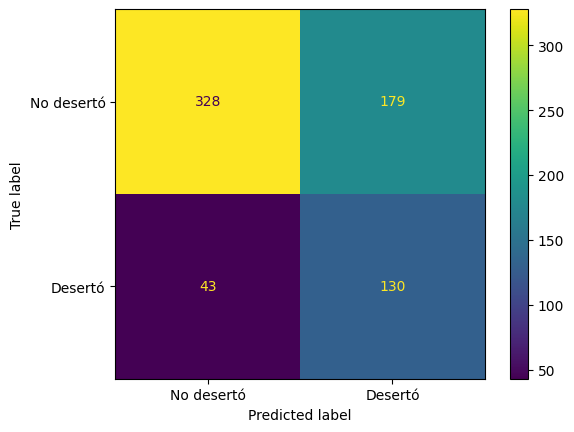

In [653]:
visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Calibración

In [654]:
xgb_cal = CalibratedClassifierCV(
    estimator=xgb_sbc,
    method='sigmoid',
    cv=5
)

xgb_cal.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.9,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='aucpr',
                                               feature_types=None,
                                               feature_weights=None, gamma=0,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.03, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=3,
                                               max_leaves=None,
                                               min_child_weight=5, missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=200, n_jobs=None,
                                               num_parallel_tree=None, ...))

In [655]:
y_proba_cal = xgb_cal.predict_proba(X_val)[:, 1]

In [656]:
thresholds = np.arange(0.1, 0.3, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba_cal >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.10,0.284298,0.994220,0.442159,605
1,0.11,0.310345,0.988439,0.472376,551
2,0.12,0.326000,0.942197,0.484398,500
3,0.13,0.335430,0.924855,0.492308,477
4,0.14,0.345652,0.919075,0.502370,460
5,0.15,0.349776,0.901734,0.504039,446
6,0.16,0.361045,0.878613,0.511785,421
7,0.17,0.370647,0.861272,0.518261,402
8,0.18,0.380829,0.849711,0.525939,386
9,0.19,0.392371,0.832370,0.533333,367


### Umbral: 0.22

In [657]:
umbral_xgb_cal = 0.24

{'Accuracy': 0.6604, 'F1': 0.5143, 'Recall': 0.7083, 'Precision': 0.4037}


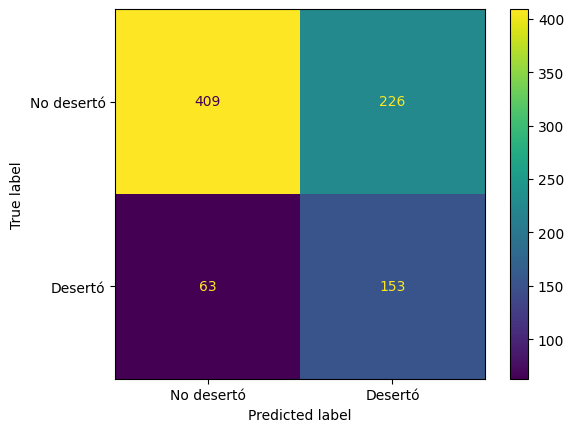

In [658]:
# Testing con el conjunto de prueba
y_proba = xgb_cal.predict_proba(X_test)[:, 1]

y_pred = (y_proba >= umbral_xgb_cal).astype(int)

# Metricas
print(calcularMetricas(y_test, y_pred))

# Matriz de confusión
visualizer = matriz_confusion(y_test, y_pred)
plt.show()

# 12. Informe

## Features usadas en cada modelo


Modelo de Regresión Logistica CON SMOTE: 'premium_mensual', 'tipo_contrato_mensual', 'antiguedad', 'facturas_impagas',
 'frecuencia_uso'

---
Modelo de Regresión Logistica SIN SMOTE: 'facturas_impagas', 'antiguedad', 'tipo_contrato_mensual', 'frecuencia_uso',
 'cambios_plan', 'plan_premium', 'canal_adquisicion_referido'

---
Modelo RandomForest: 'tipo_contrato_mensual', 'facturas_impagas',
       'metodo_pago_tarjeta_debito', 'plan_premium',
       'canal_adquisicion_referido'

---
Modelo XGBOOST: 'tipo_contrato_mensual', 'metodo_pago_tarjeta_debito' 'plan_premium',
 'canal_adquisicion_referido', 'metodo_pago_tarjeta_credito',
 'canal_adquisicion_redes_sociales'


---
Modelo XGBOOST sin SMOTE ni scale_pos_weight: 'facturas_impagas', 'tipo_contrato_mensual', 'premium_mensual'
 'cliente_problematico', 'frecuencia_uso', 'plan_premium'
 'friccion_del_servicio', 'canal_adquisicion_referido'

## Metricas, modelos ya calibrados

TODOS FUERON EVALUADOS CON EL CONJUNTO DE PRUEBA


Modelo de Regresión Logistica CON SMOTE *(Umbral elegido: 0.4)*: **{'Accuracy': 0.4888, 'F1': 0.4556, 'Recall': 0.8426, 'Precision': 0.3122}**

---

Modelo de Regresión Logistica SIN SMOTE *(Umbral elegido: 0.2)*: **{'Accuracy': 0.5018, 'F1': 0.4687, 'Recall': 0.8657, 'Precision': 0.3213}**

---

Modelo RandomForest *(Umbral elegido: 0.52)*: **{'Accuracy': 0.6381, 'F1': 0.5096, 'Recall': 0.7407, 'Precision': 0.3883}**

---

Modelo XGBOOST con SMOTE *(Umbral elegido: 0.46)*: **{'Accuracy': 0.5182, 'F1': 0.4689, 'Recall': 0.838, 'Precision': 0.3255}**

---

Modelo XGBOOST sin SMOTE ni scale_pos_weight *(Umbral elegido: 0.24)*: **{'Accuracy': 0.6604, 'F1': 0.5143, 'Recall': 0.7083, 'Precision': 0.4037}**

## Nombres de los modelos:

xgb_cal == Modelo XGBOOST sin SMOTE ni scale_pos_weight

---

xgb_calibrado == Modelo XGBOOST con SMOTE

---

rf_calibrado == Modelo RandomForest

---

lr_calibrado_no_smote == Modelo de Regresión Logistica SIN SMOTE

---

lr_calibrado == Modelo de Regresión Logistica CON SMOTE